In [1]:
import os.path as osp
from utils import *
import mmcv
import torch
import wandb
from mmcv import Config
from mmcv.parallel import MMDistributedDataParallel
from mmdet.apis import set_random_seed, train_detector
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from algo2_result_to_aligned_result import algo2_result_to_aligned_result
# Let's take a look at the dataset image
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from xml_to_np import xml_to_np
from AP import calc_iou_individual, get_single_image_results
from soft_nms import py_cpu_softnms
from dbscan_result_to_aligned_result import dbscan_result_to_aligned_result
from AP import calc_iou_individual
import xml.etree.ElementTree as ET
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from utils import print_LC

In [41]:
checkpoint_file = '/home/aiarhipov/centernet/exps/20_cycle_middle_pairing_loss_speedup/epoch_30.pth'

config_file = "/home/aiarhipov/centernet/exps/20_cycle_l1/config.py"
cfg = Config.fromfile(config_file)

set_random_seed(0, deterministic=False)

dataset = build_dataset(cfg.data.test)

model = build_detector(cfg.model)
model.CLASSES = dataset.CLASSES

model = init_detector(config_file, checkpoint_file, device='cuda:2')

loading annotations into memory...
Done (t=4.44s)
creating index...
index created!
load checkpoint from local path: /home/aiarhipov/centernet/exps/20_cycle_middle_pairing_loss_speedup/epoch_30.pth


2023-05-12 19:55:09,879 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2023-05-12 19:55:09,881 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2023-05-12 19:55:09,883 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


In [42]:
conf_threshold = 0.5
iou_threshold = 0.9
res = []
# for idx in tqdm(range(int(len(dataset)))):
idx = 7
anno = dataset.get_ann_info(idx=idx)
boxes = anno["bboxes"]
segm_path = anno["seg_map"]
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"
img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg"
xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/11e8c54bfc1c398f048045b61d12db94.xml"
print(img_path)
gt_boxes = xml_to_np(xml_path)
# print(f"gt_boxes[0] = {gt_boxes[:5]}")
pred = inference_detector(model, img_path)[0]
# pred = pred[int(len(pred)/2):]
# print(f"pred[0] = {pred[:5]}")
conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
# print(f"conf_indexes = {conf_indexes}")
conf_pred = pred[conf_indexes]
# print(f"conf_pred[0] = {conf_pred[:5]}")
# if conf_pred.shape[0] > 1:
#     conf_pred = dbscan_result_to_aligned_result([conf_pred])
#     if conf_pred:
#         conf_pred = conf_pred[0]
#         print(gt_boxes[:, :4].shape)
#         print(conf_pred[:, :4].shape)

/home/aiarhipov/datasets/WTW-dataset/test/images/11e8c54bfc1c398f048045b61d12db94.jpg


In [56]:
import warnings
from pathlib import Path

import mmcv
import numpy as np
import torch
from mmcv.ops import RoIPool
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.models import build_detector
imgs = img_path
if isinstance(imgs, (list, tuple)):
    is_batch = True
else:
    imgs = [imgs]
    is_batch = False

cfg = model.cfg
device = next(model.parameters()).device  # model device

if isinstance(imgs[0], np.ndarray):
    cfg = cfg.copy()
    # set loading pipeline type
    cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)

datas = []
for img in imgs:
    # prepare data
    if isinstance(img, np.ndarray):
        # directly add img
        data = dict(img=img)
    else:
        # add information into dict
        data = dict(img_info=dict(filename=img), img_prefix=None)
    # build the data pipeline
    data = test_pipeline(data)
    datas.append(data)

data = collate(datas, samples_per_gpu=len(imgs))
# just get the actual data from DataContainer
data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]
if next(model.parameters()).is_cuda:
    # scatter to specified GPU
    data = scatter(data, [device])[0]
else:
    for m in model.modules():
        assert not isinstance(
            m, RoIPool
        ), 'CPU inference with RoIPool is not supported currently.'

# forward the model
with torch.no_grad():
    results = model(return_loss=False, rescale=True, **data)

# model.forward(data['img'], data['img_metas'], return_loss=False)
center_heatmap_preds, offset_preds, center2vertex_pred, vertex2center_pred = model.bbox_head(model.extract_feat(data['img'][0]))

In [69]:
gt_boxes[:, :4]
np.ones(gt_boxes.shape[0])
center_heatmap_preds[0].shape
data['img_metas']
center2vertex_pred[0]
vertex2center_pred[0]
model.bbox_head.get_targets(torch.tensor(gt_boxes[:, :4], device="cuda:2"), torch.tensor(np.ones(gt_boxes.shape[0]), device="cuda:2"), center_heatmap_preds[0].shape, data['img'][0].shape, center2vertex_pred[0], vertex2center_pred[0])

IndexError: too many indices for tensor of dimension 1

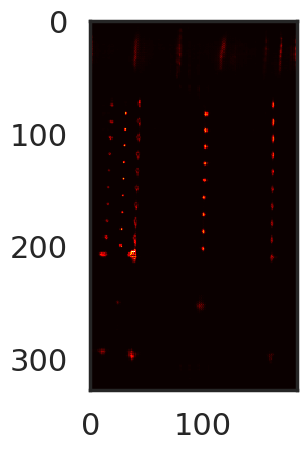

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(a[0][1].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [4]:
# conf_pred = conf_pred.astype(int)
# conf_pred[0, 0], conf_pred[0, 2]
# conf_pred = conf_pred[(conf_pred[:, 0] != conf_pred[:, 2]) & (conf_pred[:, 1] != conf_pred[:, 3])]

In [22]:
# [conf_pred[(conf_pred[:, 0] < 20)&(conf_pred[:, 1] <30)]]
conf_pred[(conf_pred.astype(int)[:, 0] == conf_pred.astype(int)[:, 2])]

array([[300.76, 172.67, 300.76, 172.67,   0.8 ],
       [658.72, 208.38, 658.72, 208.38,   0.79],
       [121.22, 279.53, 121.22, 279.53,   0.79],
       ...,
       [299.62, 387.82, 299.62, 387.82,   0.4 ],
       [119.59, 316.45, 119.59, 316.45,   0.4 ],
       [301.18, 351.98, 301.18, 351.98,   0.61]], dtype=float32)

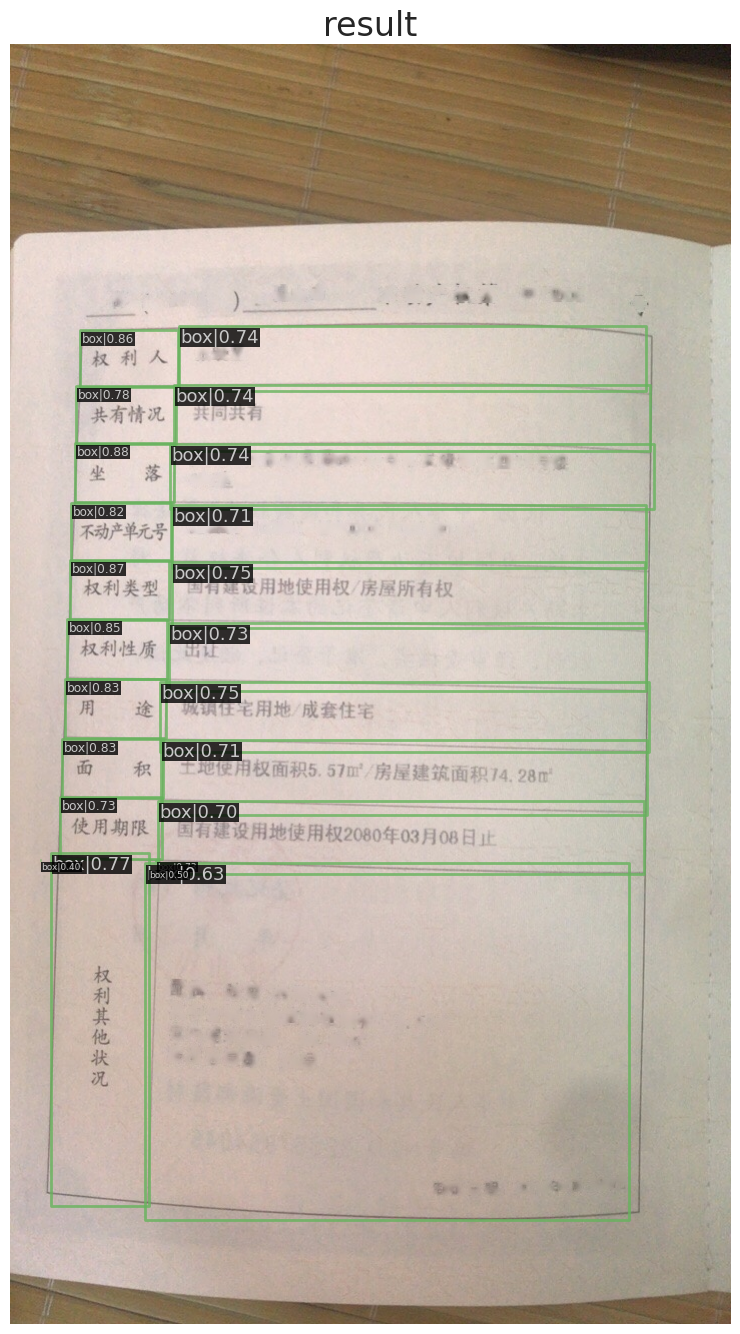

In [39]:
show_result_pyplot(model, img_path, [conf_pred[(conf_pred.astype(int)[:, 0] != conf_pred.astype(int)[:, 2])]], score_thr = 0.)